In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file_names=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        file_names.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import matplotlib.pyplot as plt

def see_image(x):
    z=plt.imread(x)
    plt.imshow(z)
    print(z.shape)

(4000, 6000, 3)


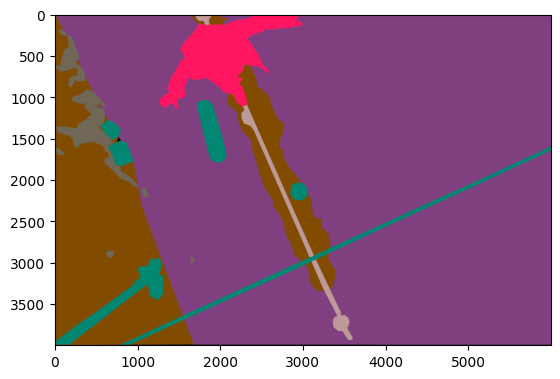

In [5]:
see_image("/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/304.png")

(4000, 6000)


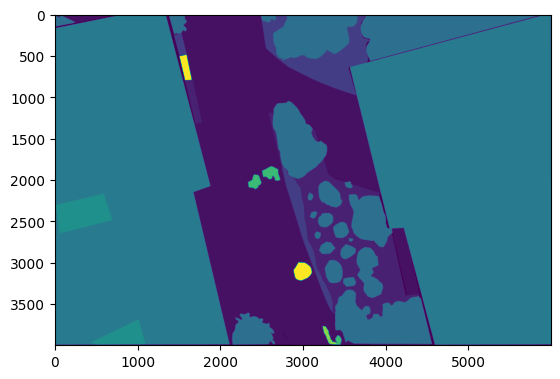

In [6]:
see_image("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/077.png")

(4000, 6000, 3)


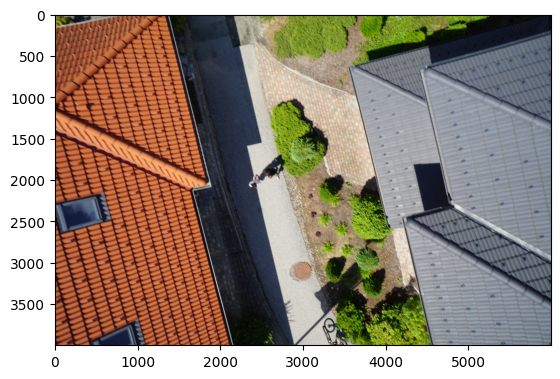

In [7]:
see_image("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/077.jpg")

In [8]:
file_names.sort()

In [ ]:
#file_names

In [9]:
k=file_names.index('/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/598.png')

color_images_mask=[]
for i in range(0,k+1):
    color_images_mask.append(file_names[i])


In [10]:
label_images_semantic=[]
z=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png")

print(z)

z1=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/598.png")
print(z1)

for i in range(z,z1+1):
    label_images_semantic.append(file_names[i])
    

401
800


In [11]:
original_images=[]

z2=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg")
z3=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/598.jpg")
print(z2,z3)


for i in range(z2,z3+1):
    original_images.append(file_names[i])

801 1200


In [12]:
#now we have the images 
#now lets differentiate them into the train and the test set 
train_original_images=[]
test_original_images=[]

train_label_images_semantic=[]
test_label_images_semantic=[]

n=len(original_images)
print(n*0.85)

340.0


In [13]:
for i in range(len(original_images)):
    if i<20:
        train_original_images.append(plt.imread(original_images[i]))
        train_label_images_semantic.append(plt.imread(label_images_semantic[i]))
    elif i<25:
        test_original_images.append(plt.imread(original_images[i]))
        test_label_images_semantic.append(plt.imread(label_images_semantic[i]))
        


In [ ]:
'''
import tensorflow as tf

def resize_images(images, target_size):
    resized_images = tf.image.resize(images, target_size)
    return resized_images

target_size = (256, 256)  # Example target size

train_original_images_resized = resize_images(train_original_images, target_size)
train_label_images_semantic_resized = resize_images(train_label_images_semantic, target_size)
'''

Now we have the training and the testing dataset , we now create and define our model 


In [36]:
#first we import the needed dependencies 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense,Input,Conv2D,GlobalAveragePooling2D,MaxPool2D,Add,BatchNormalization,Reshape,UpSampling2D,Concatenate
from keras.utils import plot_model
from keras.models import Model
from IPython.display import display,Image
from tensorflow.keras.losses import CategoricalCrossentropy

Here the input of the psp net model would be a 4000x6000x3  we will give this image to our model 
and we will subsequently downsample the model  using  the maxpool2d 

In [37]:
class PSP_net():
    def __init__(self):
        self.input_size=(4000,6000,3)
        self.padding='same'
        self.activation='relu'
        self.model=None
    
    def build_model(self):
        input1=Input(self.input_size)
        maxpool_1=MaxPool2D()(input1)
        maxpool_2=MaxPool2D()(maxpool_1)
        conv_1=Conv2D(16,3,padding=self.padding,activation=self.activation)(maxpool_2)
        batch_normalization1=BatchNormalization()(conv_1)
        conv_2=Conv2D(32,3,padding=self.padding,activation=self.activation)(batch_normalization1)
        conv_3=Conv2D(16,5,padding=self.padding,activation=self.activation)(conv_2)
        batch_normalization=BatchNormalization()(conv_3)
        conv_4=Conv2D(3,3,padding=self.padding,activation=self.activation)(batch_normalization)
        #now here we integrate the pyramid pooling layer
        
        conv_5=Conv2D(1,1,activation=self.activation,padding=self.padding)(conv_4) #this will give the size as 1x1
        global_average_pooling=GlobalAveragePooling2D()(conv_5)
        
        # Reshape to 4D tensor
        global_average_pooling_reshaped = Reshape((1, 1, 1))(global_average_pooling)
        
        
        #here we write the second scale 
        
        conv_6=Conv2D(1,1,padding=self.padding,activation=self.activation)(conv_4)
        maxpool_3=MaxPool2D((500,750))(conv_6) #this will give the size as 2x2
        
        #the third part with size 4x4
        
        conv_7=Conv2D(1,1,padding=self.padding,activation=self.activation)(conv_4)
        maxpool_4=MaxPool2D((250,375))(conv_7)
        
        #now after getting the 1x1 ,2x2 and the 4x4 model 
        #we would upsample the downsampled feature and try to bring it to the same dimension 
        upsampling_1=UpSampling2D((1000,1500),interpolation='nearest')(global_average_pooling_reshaped)
        upsampling_2=UpSampling2D((500,750),interpolation='bilinear')(maxpool_3)
        upsampling_3=UpSampling2D((250,375),interpolation='bilinear')(maxpool_4)
        
        #now after getting the upsampled  values , we would add them 
        
        concatenate_layer=Concatenate()([upsampling_1,upsampling_2,upsampling_3])
        
        #and then add the conv layer output feature vector to the following concatenate_layer 
        add_layer=Add()([concatenate_layer,conv_4])
        
        conv_8=Conv2D(1,1,padding=self.padding,activation=self.activation)(add_layer)
        Upsample_layer=UpSampling2D((4,4),interpolation='lanczos5')(conv_8)
        
        
        model=Model(inputs=input1,outputs=Upsample_layer)
        
        self.model=model
        return self.model #this returns the model 
        
        
    def summary_model(self):
        self.model.summary() 
        
        
    def plot_model(self):
        plot_model(self.model,show_shapes=True,show_layer_names=True,to_file='model.png')
        display(Image('model.png'))
        
    def compile_model(self):
        self.model.compile(loss=CategoricalCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'],run_eagerly=True)
        
        
        
        
        
        
    
    

In [38]:
psp_model=PSP_net()

k=psp_model.build_model()

In [39]:
psp_model.summary_model()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 4000,      │          0 │ -                 │
│ (InputLayer)        │ 6000, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 2000,      │          0 │ input_layer_3[0]… │
│ (MaxPooling2D)      │ 3000, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 1000,      │          0 │ max_pooling2d_12… │
│ (MaxPooling2D)      │ 1500, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 1000,      │        448 │ max_pooling2d_13… │
│                     │ 1500, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000,      │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 1500, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 1000,      │      4,640 │ batch_normalizat… │
│                     │ 1500, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 1000,      │     12,816 │ conv2d_25[0][0]   │
│                     │ 1500, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000,      │         64 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 1500, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 1000,      │        435 │ batch_normalizat… │
│                     │ 1500, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 1000,      │          4 │ conv2d_27[0][0]   │
│                     │ 1500, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ conv2d_28[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 1000,      │          4 │ conv2d_27[0][0]   │
│                     │ 1500, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 1000,      │          4 │ conv2d_27[0][0]   │
│                     │ 1500, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 1)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 2, 2, 1)   │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 4, 4, 1)   │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 1000,      │          0 │ reshape_3[0][0]   │
│ (UpSampling2D)      │ 1500, 1)          │            │                 

 Total params: 18,483 (72.20 KB)

 Trainable params: 18,419 (71.95 KB)

 Non-trainable params: 64 (256.00 B)

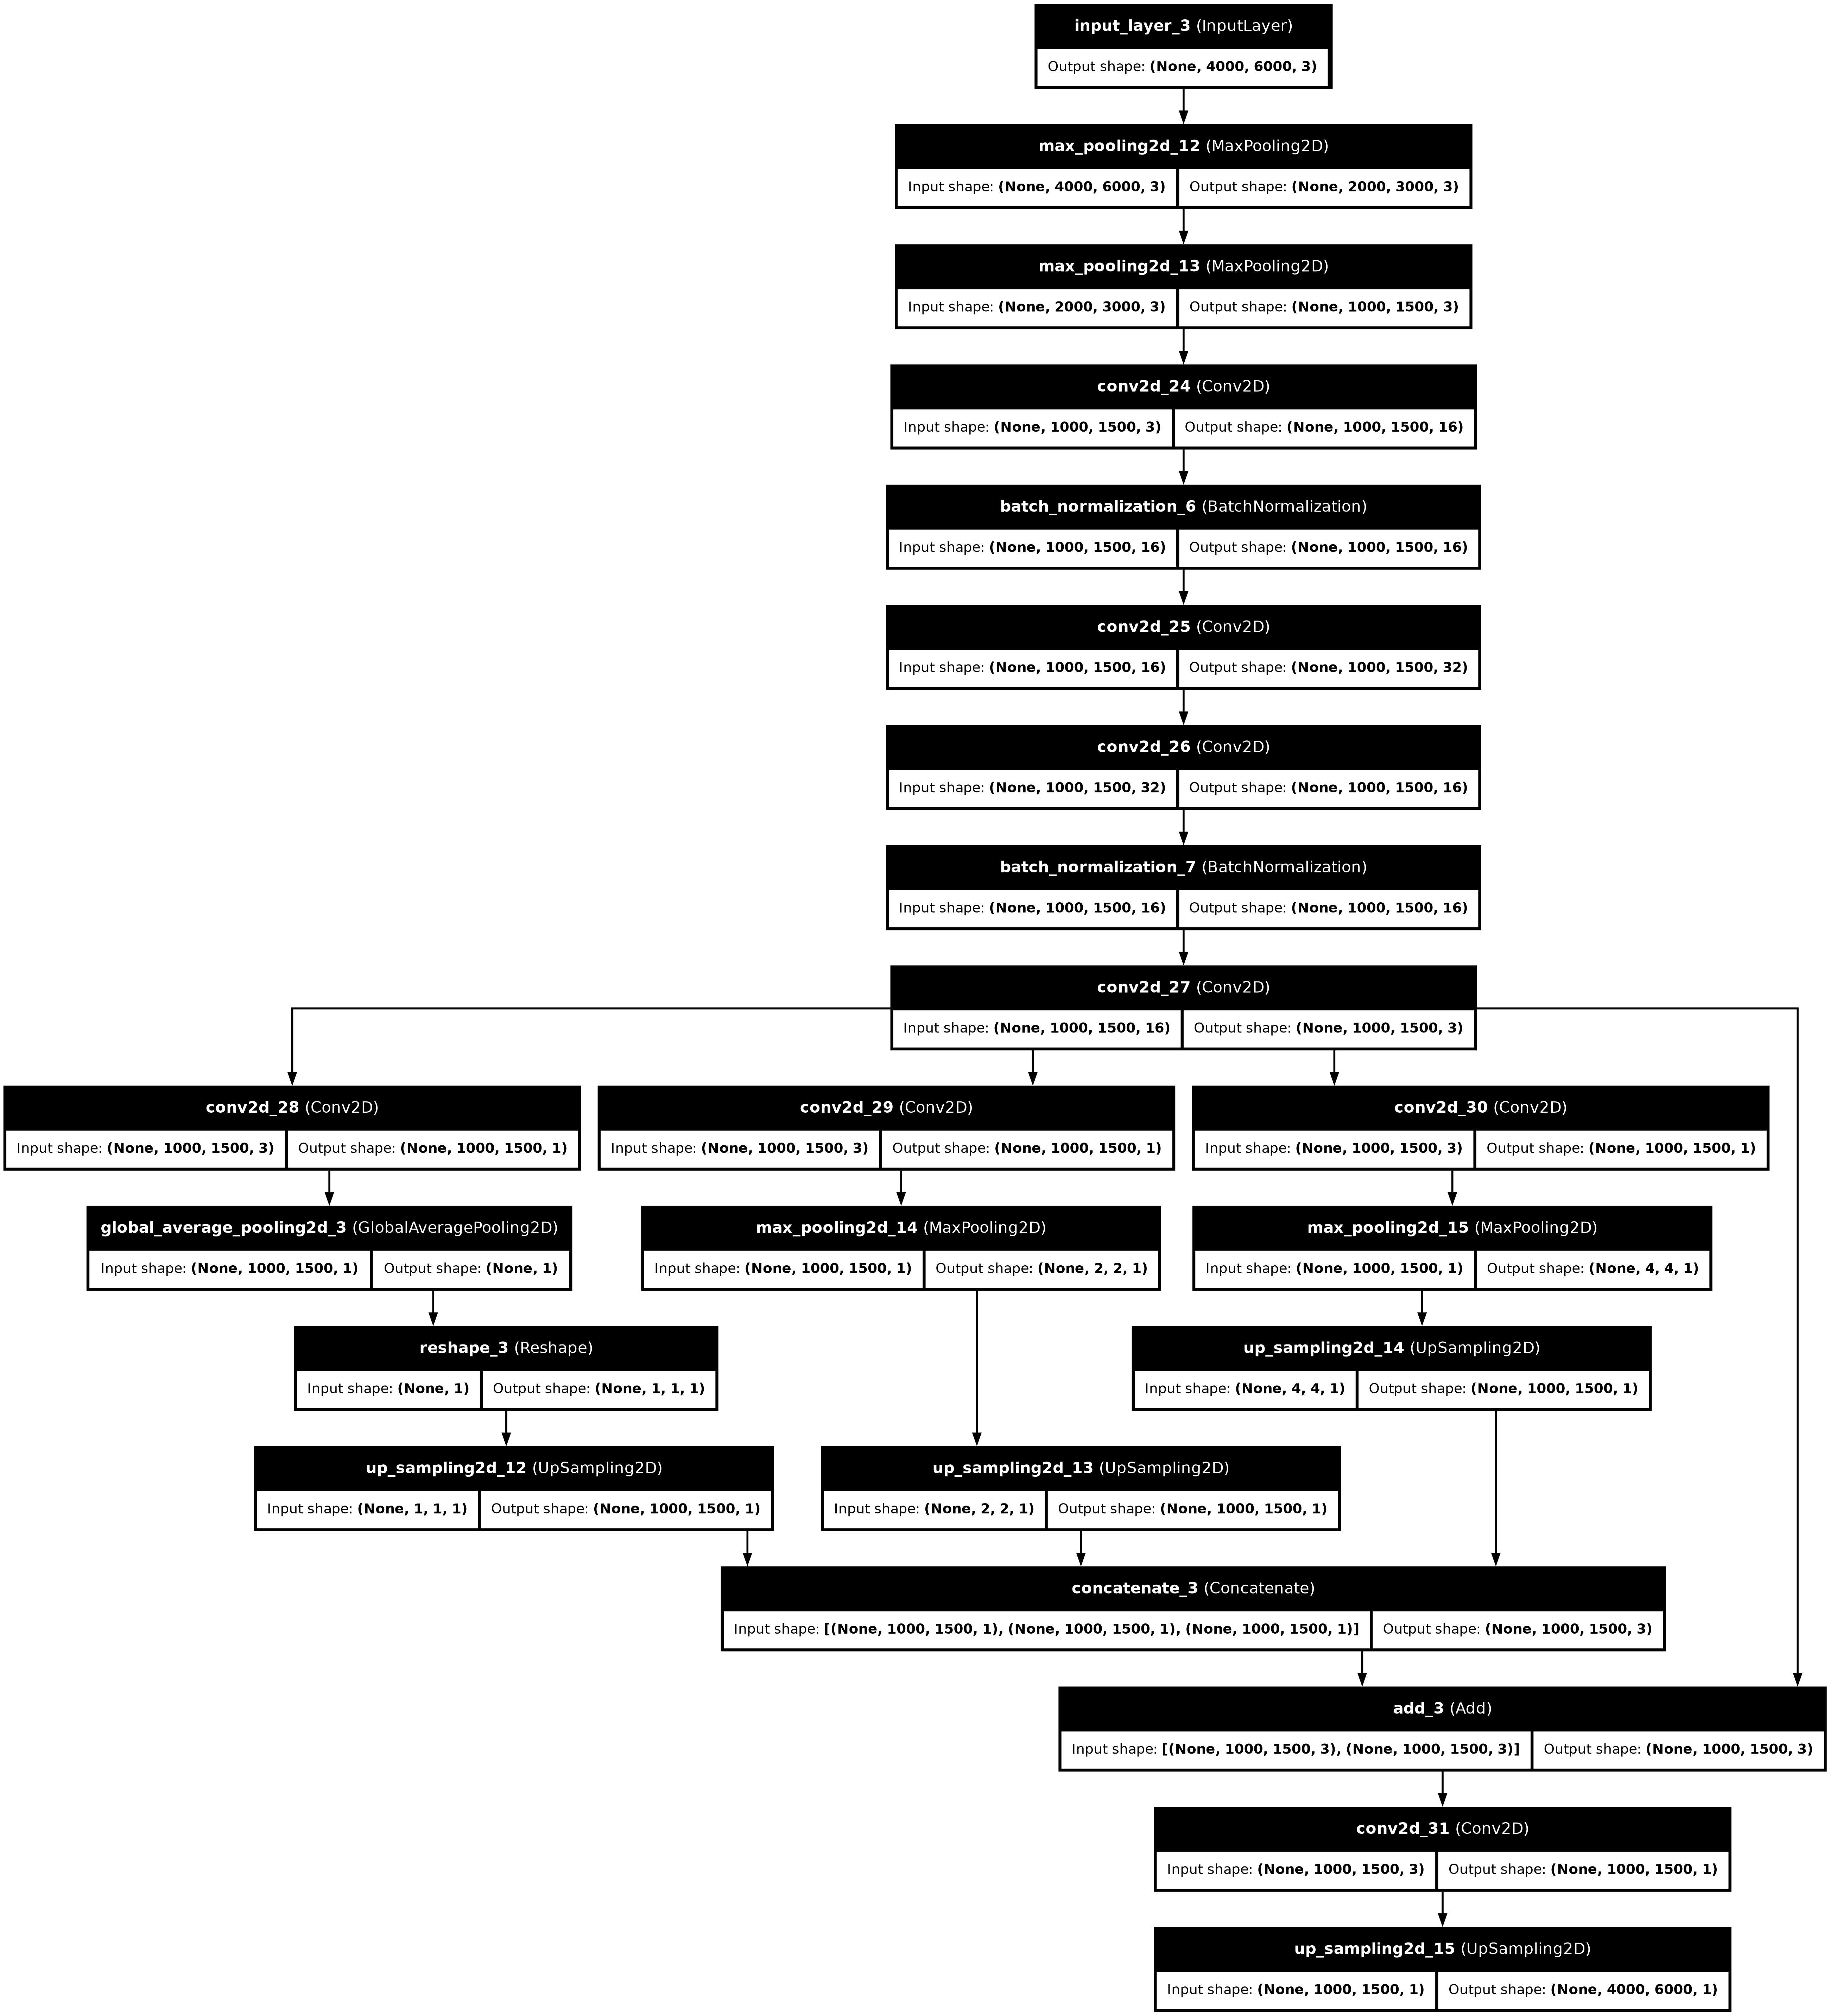

In [40]:

#now after getting the model 
#lets plot the model
psp_model.plot_model()



In [41]:
psp_model.compile_model()

In [42]:
import numpy as np

train_original_images=np.asarray(train_original_images)
train_label_images_semantic=np.asarray(train_label_images_semantic)

In [43]:
k.fit(train_original_images,train_label_images_semantic,verbose=1,batch_size=1,epochs=2)
        

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.